In [1]:
import freud
import gsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
def snap_bond_graph(snap):
    """
    Given a snapshot from a trajectory return an array
    corresponding to the molecule index of each particle 
    
    Parameters
    ----------
    snap : gsd.hoomd.Snapshot

    Returns
    -------
    numpy array (N_particles,)
    
    """
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:,0],snap.bonds.group[:,1])),
        shape=(snap.particles.N,snap.particles.N)
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels


def gsd_rdf(
    gsdfile, A_name, B_name, start=0, stop=None, rmax=None, rmin=0, bins=50, 
    exclude_bonded=True
):
    """
    This function calculates the radial distribution function given
    a gsd file and the names of the particles. By default it will calculate
    the rdf for the entire the trajectory.

    Parameters
    ----------
    gsdfile : str, filename of the gsd trajectory
    A_name, B_name : str, name(s) of particles between which to calculate the rdf
                     (found in gsd.hoomd.Snapshot.particles.types)
    start : int, which frame to start accumulating the rdf (default 0)
            (negative numbers index from the end)
    stop : int, which frame to stop accumulating the rdf (default None)
           If none is given, the function will default to the last frame.
    rmax : float, maximum radius to consider. (default None)
           If none is given, it'll be the minimum box length / 4
    bins : int, number of bins to use when calculating the distribution.
    exclude_bonded : bool, whether to remove particles in same molecule from the neighborlist
                     (default True)
                     
    NOTE: It is assumed that the bonding and the number of particles does not change 
    during the simulation

    Returns
    -------
    freud.density.RDF
    """
    with gsd.hoomd.open(gsdfile) as t:
        snap = t[0]

        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
        
        if exclude_bonded:
            molecules = snap_bond_graph(snap)
            
        for snap in t[start:stop]:

            aq = freud.locality.AABBQuery.from_system(snap)
            nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()
            
            type_A = snap.particles.typeid == snap.particles.types.index(A_name)
            if A_name != B_name:
                type_B = snap.particles.typeid == snap.particles.types.index(B_name)
            else:
                type_B = type_A
            
            nlist.filter(
                np.logical_and(
                    type_A[nlist.query_point_indices], type_B[nlist.point_indices]
                )
            )
            
            if exclude_bonded:  
                nlist.filter(
                    molecules[nlist.query_point_indices] != molecules[nlist.point_indices]
                )
                
            rdf.compute(aq, neighbors=nlist, reset=False)
            return rdf

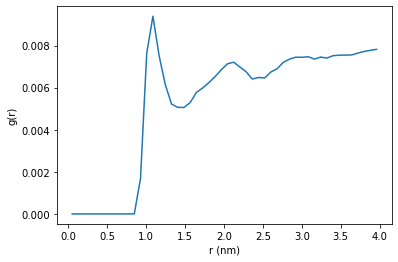

CPU times: user 5min 56s, sys: 11.2 s, total: 6min 8s
Wall time: 2min 2s


In [3]:
%%time
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=4)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()

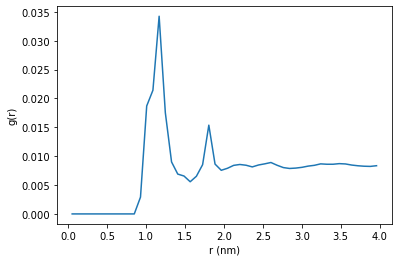

CPU times: user 6min 5s, sys: 12.9 s, total: 6min 18s
Wall time: 2min 8s


In [4]:
%%time
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=4, exclude_bonded=False)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()